<a href="https://colab.research.google.com/github/mehrnazeraeisi/Diabetes/blob/main/Diabetes_KnnClassification_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_diabetes
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

In [5]:
# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)

In [17]:
# Load dataset
data = load_diabetes()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_raw = data.target.copy()  # مقادیر اصلی

# تقسیم‌بندی پزشکی بر اساس مقدار قند خون فرضی (target)
def glucose_level_class(value):
    if value < 80:
        return 0  # Low
    elif value < 126:
        return 1  # Normal
    else:
        return 2  # High

# اعمال تابع برای تبدیل target به کلاس
y_class = np.array([glucose_level_class(val) for val in y_raw])

# حالا target جدید جایگزین y اصلی می‌شود
y_data = y_class
all_features = data.feature_names


In [18]:

# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, all_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)

🔎 Feature-wise Accuracy Ranking:
  Feature  Accuracy
8      s5  0.683258
2     bmi  0.660633
5      s2  0.626697
4      s1  0.622172
6      s3  0.588235
9      s6  0.572398
1     sex  0.565611
0     age  0.549774
3      bp  0.547511
7      s4  0.436652


In [27]:
# [5] Group features based on accuracy thresholds

medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()
poor_features = feature_scores[feature_scores['Accuracy'] <= 0.5]['Feature'].tolist()

In [29]:
# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features,  medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

In [32]:
# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features',  'Medium_1 (0.9-0.95)', 'Medium_2 (0.8-0.9)',
                      'Medium_3 (0.7-0.8)', 'Medium_4 (0.6-0.7)', 'Medium_5 (0.5-0.6)', 'Poor Features'],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)


📊 Grouped Feature Performance Summary:
         Feature Group  Accuracy
0         All Features  0.735294
1  Medium_1 (0.9-0.95)       NaN
2   Medium_2 (0.8-0.9)       NaN
3   Medium_3 (0.7-0.8)       NaN
4   Medium_4 (0.6-0.7)  0.705882
5   Medium_5 (0.5-0.6)  0.714932
6        Poor Features  0.436652


In [44]:
# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_4, medium_5, all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_4": [],
        "medium_features_5": []
    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_4": medium_4,
        "medium_features_5": medium_5
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 10))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

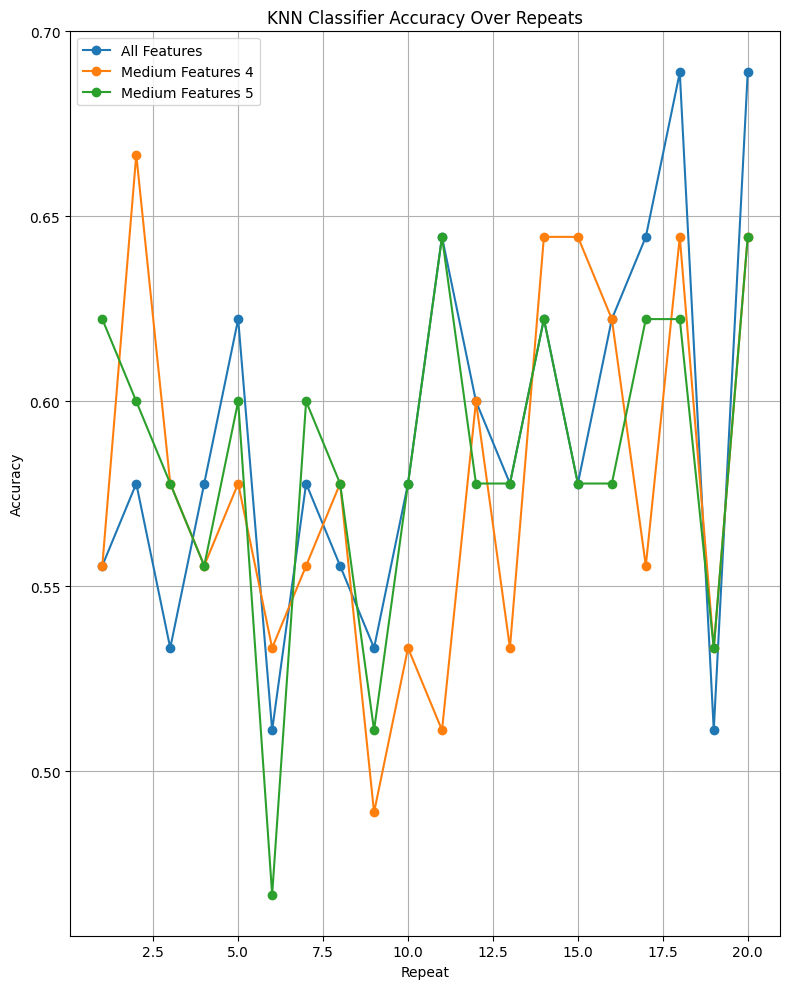

In [45]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_4, medium_features_5, all_features, test_size=0.10, n_repeats=20)

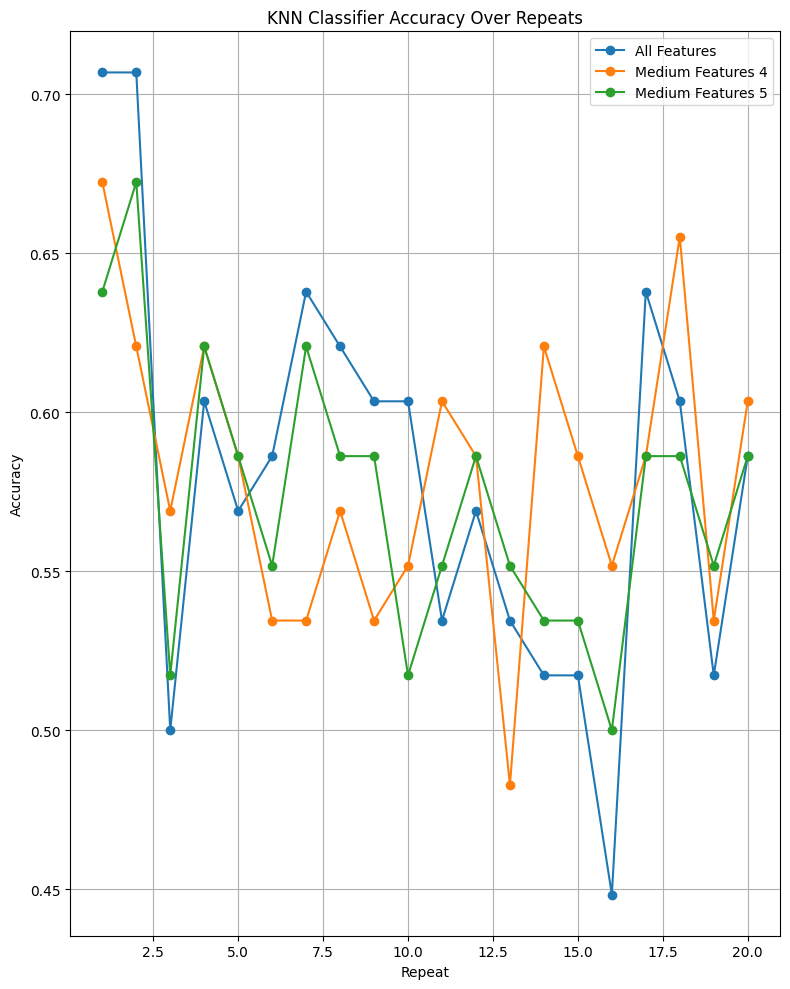

In [46]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_4, medium_features_5, all_features, test_size=0.13, n_repeats=20)

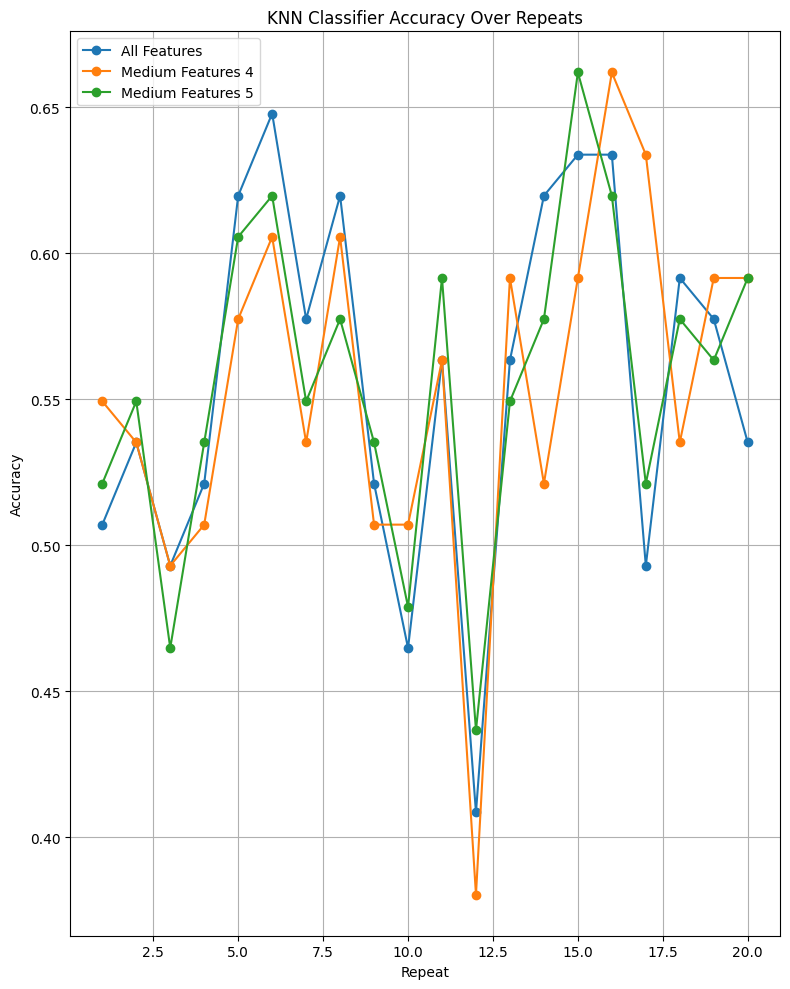

In [47]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_4, medium_features_5, all_features, test_size=0.16, n_repeats=20)

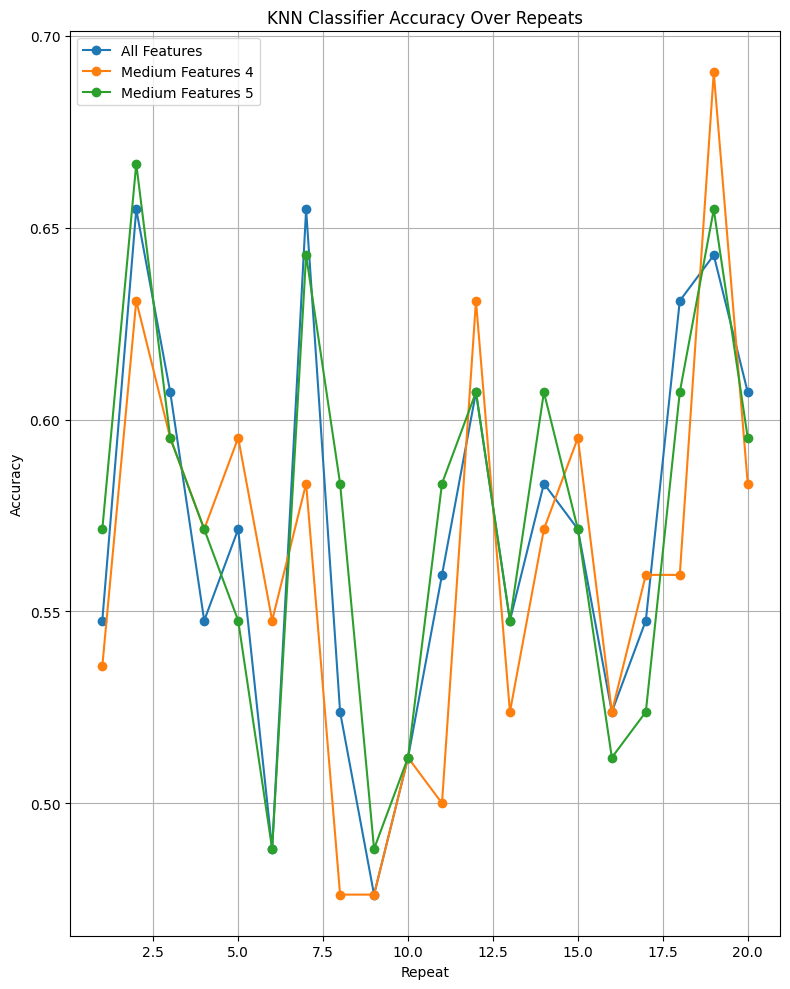

In [48]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_4, medium_features_5, all_features, test_size=0.19, n_repeats=20)


📊 Grouped Feature Performance Summary:
         Feature Group  Accuracy
0         All Features  0.735294
1  Medium_1 (0.9-0.95)       NaN
2   Medium_2 (0.8-0.9)       NaN
3   Medium_3 (0.7-0.8)       NaN
4   Medium_4 (0.6-0.7)  0.705882
5   Medium_5 (0.5-0.6)  0.714932
6        Poor Features  0.436652


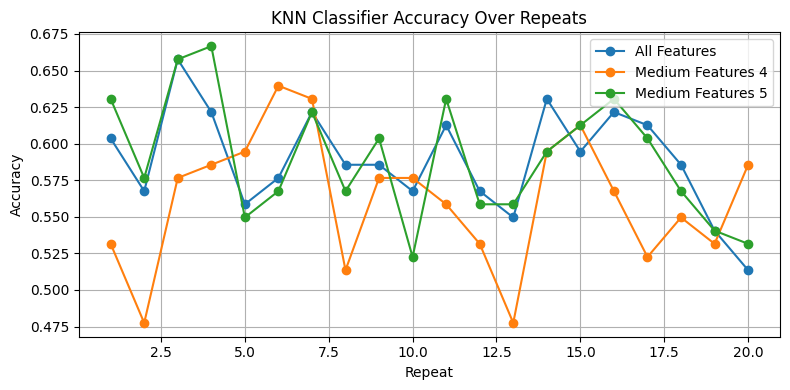

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_diabetes
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)


# Load dataset
data = load_diabetes()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_raw = data.target.copy()  # مقادیر اصلی

# تقسیم‌بندی پزشکی بر اساس مقدار قند خون فرضی (target)
def glucose_level_class(value):
    if value < 80:
        return 0  # Low
    elif value < 126:
        return 1  # Normal
    else:
        return 2  # High

# اعمال تابع برای تبدیل target به کلاس
y_class = np.array([glucose_level_class(val) for val in y_raw])

# حالا target جدید جایگزین y اصلی می‌شود
y_data = y_class
all_features = data.feature_names


# [5] Group features based on accuracy thresholds

medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()
poor_features = feature_scores[feature_scores['Accuracy'] <= 0.5]['Feature'].tolist()

# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features,  medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features',  'Medium_1 (0.9-0.95)', 'Medium_2 (0.8-0.9)',
                      'Medium_3 (0.7-0.8)', 'Medium_4 (0.6-0.7)', 'Medium_5 (0.5-0.6)', 'Poor Features'],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)

# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_4, medium_5, all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_4": [],
        "medium_features_5": []
    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_4": medium_4,
        "medium_features_5": medium_5
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 4))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_4, medium_features_5, all_features, test_size=0.25, n_repeats=20)
